# Análisis de los resultados

## Avialability HVAC

## Importación de datos

Los archivos de datos utilizados para la evaluación del rendimiento de la política entrenada se generan a partir de los programas de evaluación que se introducen en los archivos `init_conventional.py` y `init_evaluation.py`. El primero aplica las políticas convencionales o basadas en reglas (RB) al caso evaluado, mientras que el segundo hace lo mismo pero aplicando la política entrenada con algoritmos de DRL.

### Escenario 1: Termostato convencional

Se evalúa un escenario con un equipo ideal de HVAC que utiliza un termostato basado en temperaturas de referencia. En nuestro caso, 19 °C como límite inferior y 24 °C como límite superior. Fuera de ese rango, la calefacción o refrigeración es necesaria.

Se comienza importando los datos del escenario a analizar:

In [30]:
# Import the necesaty libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Replace 'ppo_file_path' and 'rb_file_path' with the actual paths to your CSV files
rb_file_path = "C:/Users/grhen/Documents/Resultados_RLforEP/CES2024_LSTM_PPO_OnOffHVAC/CES2024_LSTM_PPO_OnOffHVAC_rb_beta05.csv"
onoff_file_path = "C:/Users/grhen/Documents/Resultados_RLforEP/CES2024_LSTM_PPO_OnOffHVAC/CES2024_LSTM_PPO_OnOffHVAC_drl_beta05.csv"
therm_file_path = "C:/Users/grhen/Documents/Resultados_RLforEP/CES2024_LSTM_PPO_DualSetPointHVAC/CES2024_LSTM_PPO_DualSetPointHVAC_drl_beta05.csv"
mass_file_path = "C:/Users/grhen/Documents/Resultados_RLforEP/CES2024_LSTM_PPO_DualSetPointOnOffHVAC/CES2024_LSTM_PPO_DualSetPointOnOffHVAC_drl_beta05.csv"
mass2_file_path = "C:/Users/grhen/Documents/Resultados_RLforEP/CES2024_LSTM_PPO2_DualSetPointOnOffHVAC/CES2024_LSTM_PPO2_DualSetPointOnOffHVAC_drl_beta05.csv"

# Read CSV files into pandas DataFrames
rb_data = pd.read_csv(rb_file_path, header=None)
onoff_data = pd.read_csv(onoff_file_path, header=None)
therm_data = pd.read_csv(therm_file_path, header=None)
mass_data = pd.read_csv(mass_file_path, header=None)
mass2_data = pd.read_csv(mass2_file_path, header=None)

# Function to clean and format the data
def clean_and_format_mass(data: pd.DataFrame):
    # Remove empty rows
    data = data.dropna(how='all')  
    
    ep_variables = {
        "To": ("Site Outdoor Air Drybulb Temperature", "Environment"),
        "Zone Mean Air Temperature": ("Zone Mean Air Temperature", "Thermal Zone: Living"),
        "v": ("Site Wind Speed", "Environment"),
        "d": ("Site Wind Direction", "Environment"),
        "RHo": ("Site Outdoor Air Relative Humidity", "Environment"),
        "RHi": ("Zone Air Relative Humidity", "Thermal Zone: Living"),
        "pres": ("Site Outdoor Air Barometric Pressure", "Environment"),
        "occupancy": ("Zone People Occupant Count", "Thermal Zone: Living"),
    }
    ep_variables = np.array(list(ep_variables.keys()))
    
    ep_meters = {
        "electricity": "Electricity:Zone:THERMAL ZONE: LIVING",
        "gas": "NaturalGas:Zone:THERMAL ZONE: LIVING",
        "heating": "Heating:DistrictHeatingWater",
        "cooling": "Cooling:DistrictCooling",
    }
    ep_meters = np.array(list(ep_meters.keys()))
    
    ep_actuators = {
        "heating_setpoint": ("Schedule:Compact", "Schedule Value", "HVACTemplate-Always 19"),
        "cooling_setpoint": ("Schedule:Compact", "Schedule Value", "HVACTemplate-Always 25"),
        "AirMassFlowRate": ("Ideal Loads Air System", "Air Mass Flow Rate", "Thermal Zone: Living Ideal Loads Air System"),
    }
    ep_actuators = np.array(list(ep_actuators.keys()))
    
    time_variables = [
        'hour',
        'day_of_year',
        'day_of_week',
        ]
    time_variables = np.array(time_variables)
    
    weather_variables = [
        'is_raining',
        'sun_is_up',
        "today_weather_beam_solar_at_time",
        ]
    weather_variables = np.array(weather_variables)
    
    prediction_obs_list = []
    predicted_variables = [
        "Dry Bulb Temperature",
        "Relative Humidity",
        "Wind Direction",
        "Wind Speed",
        "Total Sky",
        "Liquid Precipitation Depth"
    ]
    number_of_days_predicted = 2
    for day in range(number_of_days_predicted):
        for hour in range(24):
            for pv in range(len(predicted_variables)):
                prediction_obs_list.append(predicted_variables[pv]+' day '+str(day)+' hour '+str(hour))
    
    prediction_obs_list = np.array(prediction_obs_list)
    
    obs_list = np.concatenate([
        ["Agent Indicator"],
        ep_variables,
        ep_meters,
        ep_actuators,
        time_variables,
        weather_variables,
        prediction_obs_list
    ])
    
    action_list = [
        "action heating_setpoint",
        "action cooling_setpoint",
        "action_AirMassFlowRate"
    ]
    action_list = np.array(action_list)
    
    learning_list = [
        'reward',
        'terminated',
        'truncated'
    ]
    learning_list = np.array(learning_list)
    
    infos_variables = ["ppd", 'heating energy', 'cooling energy', '_occupancy', '_Ti']
    infos_variables = np.array(infos_variables)
    
    header = list(np.concatenate([obs_list, action_list, learning_list, infos_variables]))
    
    data.columns = header

    return data

def clean_and_format_therm(data: pd.DataFrame):
    # Remove empty rows
    data = data.dropna(how='all')  
    
    ep_variables = {
        "To": ("Site Outdoor Air Drybulb Temperature", "Environment"),
        "Zone Mean Air Temperature": ("Zone Mean Air Temperature", "Thermal Zone: Living"),
        "v": ("Site Wind Speed", "Environment"),
        "d": ("Site Wind Direction", "Environment"),
        "RHo": ("Site Outdoor Air Relative Humidity", "Environment"),
        "RHi": ("Zone Air Relative Humidity", "Thermal Zone: Living"),
        "pres": ("Site Outdoor Air Barometric Pressure", "Environment"),
        "occupancy": ("Zone People Occupant Count", "Thermal Zone: Living"),
    }
    ep_variables = np.array(list(ep_variables.keys()))
    
    ep_meters = {
        "electricity": "Electricity:Zone:THERMAL ZONE: LIVING",
        "gas": "NaturalGas:Zone:THERMAL ZONE: LIVING",
        "heating": "Heating:DistrictHeatingWater",
        "cooling": "Cooling:DistrictCooling",
    }
    ep_meters = np.array(list(ep_meters.keys()))
    
    ep_actuators = {
        "heating_setpoint": ("Schedule:Compact", "Schedule Value", "HVACTemplate-Always 19"),
        "cooling_setpoint": ("Schedule:Compact", "Schedule Value", "HVACTemplate-Always 25"),
    }
    ep_actuators = np.array(list(ep_actuators.keys()))
    
    time_variables = [
        'hour',
        'day_of_year',
        'day_of_week',
        ]
    time_variables = np.array(time_variables)
    
    weather_variables = [
        'is_raining',
        'sun_is_up',
        "today_weather_beam_solar_at_time",
        ]
    weather_variables = np.array(weather_variables)
    
    prediction_obs_list = []
    predicted_variables = [
        "Dry Bulb Temperature",
        "Relative Humidity",
        "Wind Direction",
        "Wind Speed",
        "Total Sky",
        "Liquid Precipitation Depth"
    ]
    number_of_days_predicted = 2
    for day in range(number_of_days_predicted):
        for hour in range(24):
            for pv in range(len(predicted_variables)):
                prediction_obs_list.append(predicted_variables[pv]+' day '+str(day)+' hour '+str(hour))
    
    prediction_obs_list = np.array(prediction_obs_list)
    
    obs_list = np.concatenate([
        ["Agent Indicator"],
        ep_variables,
        ep_meters,
        ep_actuators,
        time_variables,
        weather_variables,
        prediction_obs_list
    ])
    
    action_list = [
        "action heating_setpoint",
        "action cooling_setpoint",
    ]
    action_list = np.array(action_list)
    
    learning_list = [
        'reward',
        'terminated',
        'truncated'
    ]
    learning_list = np.array(learning_list)
    
    infos_variables = ["ppd", 'heating energy', 'cooling energy', '_occupancy', '_Ti']
    infos_variables = np.array(infos_variables)
    
    header = list(np.concatenate([obs_list, action_list, learning_list, infos_variables]))
    
    data.columns = header

    return data

# Function to clean and format the data
def clean_and_format_rb_onoff(data: pd.DataFrame):
    # Remove empty rows
    data = data.dropna(how='all')  
    
    ep_variables = {
        "To": ("Site Outdoor Air Drybulb Temperature", "Environment"),
        "Zone Mean Air Temperature": ("Zone Mean Air Temperature", "Thermal Zone: Living"),
        "v": ("Site Wind Speed", "Environment"),
        "d": ("Site Wind Direction", "Environment"),
        "RHo": ("Site Outdoor Air Relative Humidity", "Environment"),
        "RHi": ("Zone Air Relative Humidity", "Thermal Zone: Living"),
        "pres": ("Site Outdoor Air Barometric Pressure", "Environment"),
        "occupancy": ("Zone People Occupant Count", "Thermal Zone: Living"),
    }
    ep_variables = np.array(list(ep_variables.keys()))
    
    ep_meters = {
        "electricity": "Electricity:Zone:THERMAL ZONE: LIVING",
        "gas": "NaturalGas:Zone:THERMAL ZONE: LIVING",
        "heating": "Heating:DistrictHeatingWater",
        "cooling": "Cooling:DistrictCooling",
    }
    ep_meters = np.array(list(ep_meters.keys()))
    
    ep_actuators = {
        "HVAC_OnOff": ("Schedule:Constant", "Schedule Value", "HVAC_avialability"),
    }
    ep_actuators = np.array(list(ep_actuators.keys()))
    
    time_variables = [
        'hour',
        'day_of_year',
        'day_of_week',
        ]
    time_variables = np.array(time_variables)
    
    weather_variables = [
        'is_raining',
        'sun_is_up',
        "today_weather_beam_solar_at_time",
        ]
    weather_variables = np.array(weather_variables)
    
    prediction_obs_list = []
    predicted_variables = [
        "Dry Bulb Temperature",
        "Relative Humidity",
        "Wind Direction",
        "Wind Speed",
        "Total Sky",
        "Liquid Precipitation Depth"
    ]
    number_of_days_predicted = 2
    for day in range(number_of_days_predicted):
        for hour in range(24):
            for pv in range(len(predicted_variables)):
                prediction_obs_list.append(predicted_variables[pv]+' day '+str(day)+' hour '+str(hour))
    
    prediction_obs_list = np.array(prediction_obs_list)
    
    obs_list = np.concatenate([
        ["Agent Indicator"],
        ep_variables,
        ep_meters,
        ep_actuators,
        time_variables,
        weather_variables,
        prediction_obs_list
    ])
    
    action_list = [
        "action",
    ]
    action_list = np.array(action_list)
    
    learning_list = [
        'reward',
        'terminated',
        'truncated'
    ]
    learning_list = np.array(learning_list)
    
    infos_variables = ["ppd", 'Energy heating', 'Energy cooling', '_occupancy', '_Ti', '_HVAC_OnOff']
    infos_variables = np.array(infos_variables)
    
    header = list(np.concatenate([obs_list, action_list, learning_list, infos_variables]))
    
    data.columns = header

    return data

# Apply cleaning and formatting to both DataFrames
rb_data_cleaned = clean_and_format_rb_onoff(rb_data)
onoff_data_cleaned = clean_and_format_rb_onoff(onoff_data)
therm_data_cleaned = clean_and_format_therm(therm_data)
mass_data_cleaned = clean_and_format_mass(mass_data)
mass2_data_cleaned = clean_and_format_mass(mass2_data)

Se pueden analizar los resultados generales con el método `describe` de pandas para tipos `DataFrame`. Esto es útil para comprobar la correcta importación de los datos y algunos parámetros estadísticos generales de las diferentes variables.

In [31]:
# General results of the RB Policy
rb_data_cleaned.describe()

,Agent Indicator,To,Zone Mean Air Temperature,v,d,RHo,RHi,pres,occupancy,electricity,...,Total Sky day 1 hour 23,Liquid Precipitation Depth day 1 hour 23,action,reward,ppd,Energy heating,Energy cooling,_occupancy,_Ti,_HVAC_OnOff
count,52561.0,52561.000000,52561.000000,52561.000000,52561.000000,52561.000000,52561.000000,52561.000000,52561.000000,52561.000000,...,52561.000000,52561.000000,52561.0,52561.000000,52561.000000,5.256100e+04,5.256100e+04,52561.000000,52561.000000,52561.0
mean,1.0,15.700864,21.959507,4.277504,200.929767,54.465716,46.425043,89955.415955,0.916863,116047.963319,...,3.657465,0.035890,1.0,-0.000715,7.092902,6.723065e+04,1.352103e+05,0.916863,21.959507,1.0
std,0.0,7.840526,2.568914,2.306541,96.527900,18.629476,16.221409,349.454013,1.108349,193607.410932,...,3.273925,0.275382,0.0,0.009060,11.601653,1.366720e+05,2.629221e+05,1.108349,2.568914,0.0
min,1.0,-4.400000,18.991819,0.100000,0.000000,16.000000,9.144011,88704.000000,0.000000,0.000000,...,0.000000,0.000000,1.0,-0.283456,0.000000,0.000000e+00,0.000000e+00,0.000000,18.991819,1.0
25%,1.0,9.933333,19.000000,2.533333,151.000000,39.000000,35.749603,89744.664062,0.000000,0.000000,...,0.000000,0.000000,1.0,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,19.000000,1.0
50%,1.0,15.800000,21.809788,4.000000,211.833328,54.000000,42.857761,89967.000000,0.000000,0.000000,...,4.000000,0.000000,1.0,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,21.809788,1.0
75%,1.0,21.299999,24.999998,5.700000,262.000000,68.666664,55.965157,90219.000000,1.770000,147000.000000,...,6.000000,0.000000,1.0,0.000000,9.711420,6.547522e+04,1.486845e+05,1.770000,24.999998,1.0
max,1.0,37.700001,28.700531,14.800000,359.833344,100.000000,100.000000,90825.000000,3.000000,681000.000000,...,10.000000,4.300000,1.0,0.000000,65.904982,1.291014e+06,1.500000e+06,3.000000,28.700531,1.0


In [32]:
# General results of the OnOff Policy
onoff_data_cleaned.describe()

,Agent Indicator,To,Zone Mean Air Temperature,v,d,RHo,RHi,pres,occupancy,electricity,...,Total Sky day 1 hour 23,Liquid Precipitation Depth day 1 hour 23,action,reward,ppd,Energy heating,Energy cooling,_occupancy,_Ti,_HVAC_OnOff
count,52561.0,52561.000000,52561.000000,52561.000000,52561.000000,52561.000000,52561.000000,52561.000000,52561.000000,52561.000000,...,52561.000000,52561.000000,52561.000000,52561.000000,52561.000000,5.256100e+04,5.256100e+04,52561.000000,52561.000000,52561.00000
mean,1.0,15.700864,23.159689,4.277504,200.929767,54.465716,49.465705,89955.415955,0.916863,116047.963319,...,3.657465,0.035890,0.627271,-0.000682,14.272089,5.633795e+04,2.439632e+04,0.916863,23.159689,0.62729
std,0.0,7.840526,4.489868,2.306541,96.527900,18.629476,19.692995,349.454013,1.108349,193607.410932,...,3.273925,0.275382,0.483535,0.008883,23.974272,1.302650e+05,1.150777e+05,1.108349,4.489868,0.48353
min,1.0,-4.400000,11.969574,0.100000,0.000000,16.000000,5.940606,88704.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-0.285555,0.000000,0.000000e+00,0.000000e+00,0.000000,11.969574,0.00000
25%,1.0,9.933333,19.000000,2.533333,151.000000,39.000000,34.759315,89744.664062,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,19.000000,0.00000
50%,1.0,15.800000,22.172070,4.000000,211.833328,54.000000,45.843739,89967.000000,0.000000,0.000000,...,4.000000,0.000000,1.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,22.172070,1.00000
75%,1.0,21.299999,25.565512,5.700000,262.000000,68.666664,61.302132,90219.000000,1.770000,147000.000000,...,6.000000,0.000000,1.000000,0.000000,17.077700,6.096055e+03,0.000000e+00,1.770000,25.565511,1.00000
max,1.0,37.700001,40.209915,14.800000,359.833344,100.000000,100.000000,90825.000000,3.000000,681000.000000,...,10.000000,4.300000,1.000000,0.000000,99.997684,1.500000e+06,1.500000e+06,3.000000,40.209913,1.00000


In [33]:
# General results of the Thermostat Policy
therm_data_cleaned.describe()

,Agent Indicator,To,Zone Mean Air Temperature,v,d,RHo,RHi,pres,occupancy,electricity,...,Total Sky day 1 hour 23,Liquid Precipitation Depth day 1 hour 23,action heating_setpoint,action cooling_setpoint,reward,ppd,heating energy,cooling energy,_occupancy,_Ti
count,52561.0,52561.000000,52561.000000,52561.000000,52561.000000,52561.000000,52561.000000,52561.000000,52561.000000,52561.000000,...,52561.000000,52561.000000,52561.000000,52561.000000,52561.000000,52561.000000,5.256100e+04,5.256100e+04,52561.000000,52561.000000
mean,2.0,15.700864,22.030484,4.277504,200.929767,54.465716,43.893008,89955.415955,0.916863,116047.963319,...,3.657465,0.035890,0.152794,0.125511,-0.000906,5.545658,1.184685e+05,1.895828e+05,0.916863,22.030484
std,0.0,7.840526,1.132390,2.306541,96.527900,18.629476,14.154344,349.454013,1.108349,193607.410932,...,3.273925,0.275382,0.422446,0.332848,0.011223,9.192405,1.883620e+05,3.046296e+05,1.108349,1.132390
min,2.0,-4.400000,18.690390,0.100000,0.000000,16.000000,9.633519,88704.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-0.297480,0.000000,0.000000e+00,0.000000e+00,0.000000,18.690390
25%,2.0,9.933333,21.000000,2.533333,151.000000,39.000000,35.112217,89744.664062,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,21.000000
50%,2.0,15.800000,21.757130,4.000000,211.833328,54.000000,42.232231,89967.000000,0.000000,0.000000,...,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,21.757129
75%,2.0,21.299999,23.000000,5.700000,262.000000,68.666664,51.034763,90219.000000,1.770000,147000.000000,...,6.000000,0.000000,0.000000,0.000000,0.000000,7.571565,2.014848e+05,3.197057e+05,1.770000,23.000000
max,2.0,37.700001,27.799408,14.800000,359.833344,100.000000,100.000000,90825.000000,3.000000,681000.000000,...,10.000000,4.300000,3.000000,3.000000,0.000000,56.461395,1.500000e+06,1.500000e+06,3.000000,27.799408


In [34]:
# General results of the Thermostat Policy
mass_data_cleaned.describe()

,Agent Indicator,To,Zone Mean Air Temperature,v,d,RHo,RHi,pres,occupancy,electricity,...,Liquid Precipitation Depth day 1 hour 23,action heating_setpoint,action cooling_setpoint,action_AirMassFlowRate,reward,ppd,heating energy,cooling energy,_occupancy,_Ti
count,52561.0,52561.000000,52561.000000,52561.000000,52561.000000,52561.000000,52561.000000,52561.000000,52561.000000,52561.000000,...,52561.000000,52561.000000,52561.000000,52561.000000,52561.000000,52561.000000,5.256100e+04,5.256100e+04,52561.000000,52561.000000
mean,2.0,15.700864,22.237230,4.277504,200.929767,54.465716,51.101952,89955.415955,0.916863,116047.963319,...,0.035890,0.524705,0.499591,0.499591,-0.000573,13.736133,4.412407e+03,3.724871e+04,0.916863,22.237230
std,0.0,7.840526,5.142898,2.306541,96.527900,18.629476,19.577710,349.454013,1.108349,193607.410932,...,0.275382,1.350997,1.323050,1.323050,0.008006,22.161754,4.401777e+04,1.884500e+05,1.108349,5.142898
min,2.0,-4.400000,8.188308,0.100000,0.000000,16.000000,6.532005,88704.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-0.305325,0.000000,0.000000e+00,0.000000e+00,0.000000,8.188307
25%,2.0,9.933333,17.974678,2.533333,151.000000,39.000000,36.184330,89744.664062,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,17.974678
50%,2.0,15.800000,22.025591,4.000000,211.833328,54.000000,47.778339,89967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,22.025590
75%,2.0,21.299999,26.498264,5.700000,262.000000,68.666664,62.657734,90219.000000,1.770000,147000.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,19.190474,0.000000e+00,0.000000e+00,1.770000,26.498264
max,2.0,37.700001,38.604900,14.800000,359.833344,100.000000,100.000000,90825.000000,3.000000,681000.000000,...,4.300000,5.000000,5.000000,5.000000,0.000000,99.903865,1.257766e+06,1.500000e+06,3.000000,38.604901


In [35]:
# General results of the Thermostat Policy
mass2_data_cleaned.describe()

,Agent Indicator,To,Zone Mean Air Temperature,v,d,RHo,RHi,pres,occupancy,electricity,...,Liquid Precipitation Depth day 1 hour 23,action heating_setpoint,action cooling_setpoint,action_AirMassFlowRate,reward,ppd,heating energy,cooling energy,_occupancy,_Ti
count,52561.0,52561.000000,52561.000000,52561.000000,52561.000000,52561.000000,52561.000000,52561.000000,52561.000000,52561.000000,...,52561.000000,52561.000000,52561.000000,52561.000000,52561.000000,52561.000000,5.256100e+04,5.256100e+04,52561.000000,52561.000000
mean,2.0,15.700864,22.313602,4.277504,200.929767,54.465716,44.983427,89955.415955,0.916863,116047.963319,...,0.035890,2.760317,2.766481,2.766481,-0.000469,8.336858,5.935254e+04,1.045064e+05,0.916863,22.313602
std,0.0,7.840526,3.080703,2.306541,96.527900,18.629476,14.797215,349.454013,1.108349,193607.410932,...,0.275382,0.856909,0.889947,0.889947,0.006219,13.279397,1.350221e+05,2.322164e+05,1.108349,3.080703
min,2.0,-4.400000,15.887585,0.100000,0.000000,16.000000,9.610895,88704.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-0.221744,0.000000,0.000000e+00,0.000000e+00,0.000000,15.887585
25%,2.0,9.933333,19.000065,2.533333,151.000000,39.000000,34.053856,89744.664062,0.000000,0.000000,...,0.000000,2.000000,2.000000,2.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,19.000064
50%,2.0,15.800000,21.984436,4.000000,211.833328,54.000000,42.782711,89967.000000,0.000000,0.000000,...,0.000000,3.000000,3.000000,3.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,21.984435
75%,2.0,21.299999,25.772316,5.700000,262.000000,68.666664,54.186867,90219.000000,1.770000,147000.000000,...,0.000000,3.000000,3.000000,3.000000,0.000000,12.252167,1.848508e+03,1.433621e+04,1.770000,25.772316
max,2.0,37.700001,28.866674,14.800000,359.833344,100.000000,100.000000,90825.000000,3.000000,681000.000000,...,4.300000,5.000000,5.000000,5.000000,0.000000,78.124957,1.291073e+06,1.500000e+06,3.000000,28.866674


In [36]:
# rb_data_cleaned.loc[(rb_data_cleaned['ppd'] < 5), 'ppd'] = 5
# onoff_data_cleaned.loc[(onoff_data_cleaned['ppd'] < 5), 'ppd'] = 5
# therm_data_cleaned.loc[(therm_data_cleaned['ppd'] < 5), 'ppd'] = 5
# mass_data_cleaned.loc[(mass_data_cleaned['ppd'] < 5), 'ppd'] = 5

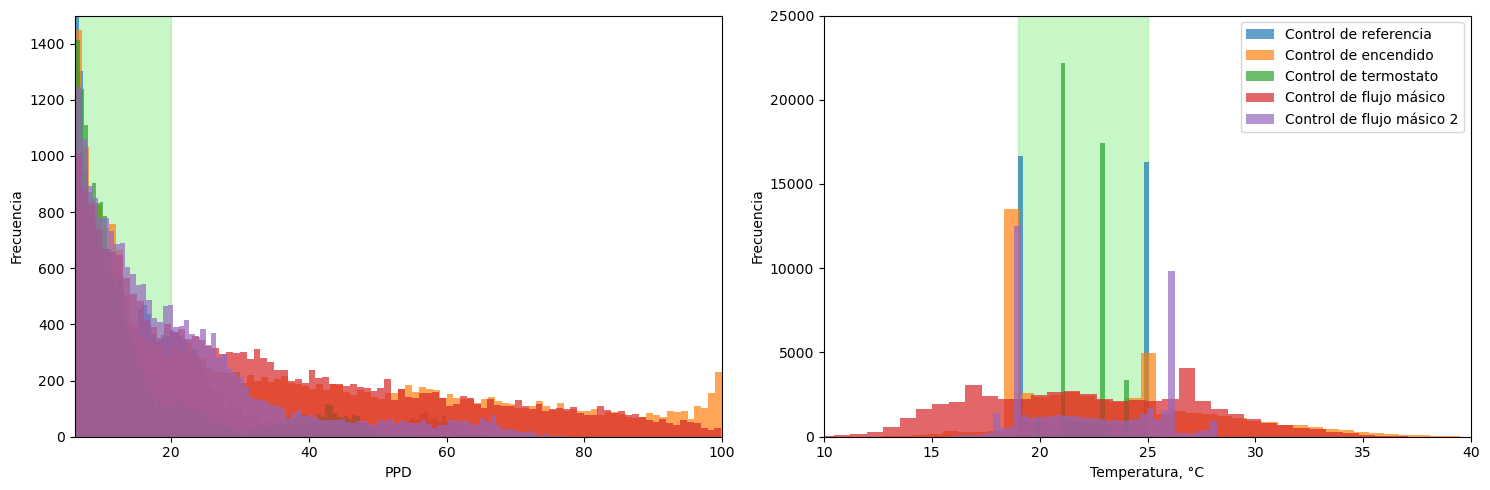

In [52]:
# Violación de rango de temperaturas de confort (27 a 20 °C).
# Histograma de distribución de temperaturas en la zona térmica y contabilización en porcentaje de 
# la cantidad de veces que se estuvo fuera del rango de confort.

# Define los rangos de temperatura de confort
rango_confort = (5, 20)  # Por ejemplo, entre 20°C y 24°C

# Grafica los histogramas
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Marca los rangos de temperatura de confort
axs[0].axvspan(rango_confort[0], rango_confort[1], color='lightgreen', alpha=0.5)
axs[0].hist(rb_data_cleaned["ppd"], bins=100, alpha=0.7, label="Control de referencia")
axs[0].hist(onoff_data_cleaned["ppd"], bins=100, alpha=0.7, label="Control de encendido")
axs[0].hist(therm_data_cleaned["ppd"], bins=100, alpha=0.7, label="Control de termostato")
axs[0].hist(mass_data_cleaned["ppd"], bins=100, alpha=0.7, label="Control de flujo másico")
axs[0].hist(mass2_data_cleaned["ppd"], bins=100, alpha=0.7, label="Control de flujo másico 2")

axs[0].set_xlabel('PPD')
axs[0].set_ylabel('Frecuencia')
axs[0].set_xlim(6, 100)
axs[0].set_ylim(0, 1500)

# Define los rangos de temperatura de confort
rango_confort = (22-3, 22+3)  # Por ejemplo, entre 20°C y 24°C
axs[1].axvspan(rango_confort[0], rango_confort[1], color='lightgreen', alpha=0.5)
axs[1].hist(rb_data_cleaned["Zone Mean Air Temperature"], bins=40, alpha=0.7, label="Control de referencia")
axs[1].hist(onoff_data_cleaned["Zone Mean Air Temperature"], bins=40, alpha=0.7, label="Control de encendido")
axs[1].hist(therm_data_cleaned["Zone Mean Air Temperature"], bins=40, alpha=0.7, label="Control de termostato")
axs[1].hist(mass_data_cleaned["Zone Mean Air Temperature"], bins=40, alpha=0.7, label="Control de flujo másico")
axs[1].hist(mass2_data_cleaned["Zone Mean Air Temperature"], bins=40, alpha=0.7, label="Control de flujo másico 2")

axs[1].set_xlabel('Temperatura, °C')
axs[1].set_ylabel('Frecuencia')
axs[1].set_xlim(10, 40)
axs[1].set_ylim(0, 25000)
plt.legend()
plt.tight_layout()
plt.show()

In [38]:
rb_h = rb_data_cleaned["heating"].sum()
drl_h = mass_data_cleaned["heating"].sum()

rate_h = round(1-drl_h/rb_h,4)

rb_c = rb_data_cleaned["cooling"].sum()
drl_c = mass_data_cleaned["cooling"].sum()

rate_c = round(1-drl_c/rb_c,4)

rb_T = rb_h + rb_c
drl_T = drl_h + drl_c

rate_T = round(1-drl_T/rb_T,4)

print(f"La tasa de variación de calefacción es {rate_h}, mientras que la de refrigeración es de {rate_c}. Esto indica una variación total de {rate_T}")

La tasa de variación de calefacción es 0.9344, mientras que la de refrigeración es de 0.7245. Esto indica una variación total de 0.7942


Es importante tener en cuenta que aquí la política utilizada para operar las sombras siempre fue la convencional, por lo que las modificaciones presentadas responden a la modificación introducida en el entorno y no a un aprendizaje de política para estos dispositivos. Como acción futura se quiere optimizar la política para el control de sombras.

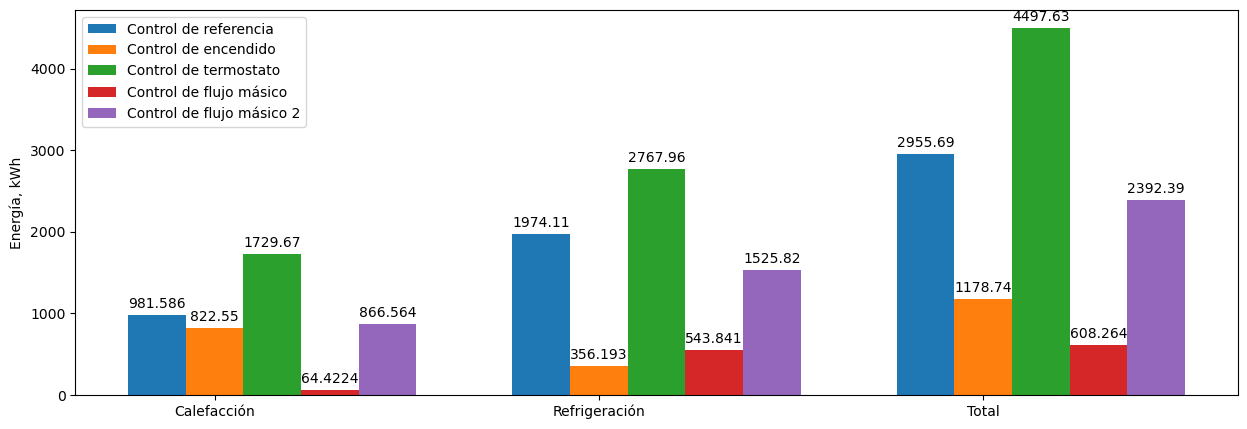

In [53]:
# data from https://allisonhorst.github.io/palmerpenguins/
species = ('Calefacción', 'Refrigeración', 'Total')
penguin_means = {
    'Control de referencia': (rb_data_cleaned["heating"].sum()/(3.6*10**6),
                              rb_data_cleaned["cooling"].sum()/(3.6*10**6),
                              rb_data_cleaned["heating"].sum()/(3.6*10**6)+rb_data_cleaned["cooling"].sum()/(3.6*10**6)),
    'Control de encendido': (onoff_data_cleaned["heating"].sum()/(3.6*10**6),
                              onoff_data_cleaned["cooling"].sum()/(3.6*10**6),
                              onoff_data_cleaned["heating"].sum()/(3.6*10**6)+onoff_data_cleaned["cooling"].sum()/(3.6*10**6)),
    'Control de termostato': (therm_data_cleaned["heating"].sum()/(3.6*10**6),
                              therm_data_cleaned["cooling"].sum()/(3.6*10**6),
                              therm_data_cleaned["heating"].sum()/(3.6*10**6)+therm_data_cleaned["cooling"].sum()/(3.6*10**6)),
    'Control de flujo másico': (mass_data_cleaned["heating"].sum()/(3.6*10**6),
                              mass_data_cleaned["cooling"].sum()/(3.6*10**6),
                              mass_data_cleaned["heating"].sum()/(3.6*10**6)+mass_data_cleaned["cooling"].sum()/(3.6*10**6)),
    'Control de flujo másico 2': (mass2_data_cleaned["heating"].sum()/(3.6*10**6),
                              mass2_data_cleaned["cooling"].sum()/(3.6*10**6),
                              mass2_data_cleaned["heating"].sum()/(3.6*10**6)+mass2_data_cleaned["cooling"].sum()/(3.6*10**6)),

}

x = np.arange(len(species))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(15, 5))

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Energía, kWh')
ax.set_xticks(x + width, species)
ax.legend()

plt.show()

In [54]:
def policy_analisys(rb_data_cleaned, onoff_data_cleaned, therm_data_cleaned, mass_data_cleaned, mass2_data_cleaned, a:int=None, b:int=None, To: bool = True):
    
    if a == None and b == None:
        rb_filtered_data=rb_data_cleaned.iloc[:]
        onoff_filtered_data=onoff_data_cleaned.iloc[:]
        therm_filtered_data=therm_data_cleaned.iloc[:]
        mass_filtered_data=mass_data_cleaned.iloc[:]
        mass2_filtered_data=mass2_data_cleaned.iloc[:]
    elif a == None and b != None:
        rb_filtered_data=rb_data_cleaned.iloc[:b]
        onoff_filtered_data=onoff_data_cleaned.iloc[:b]
        therm_filtered_data=therm_data_cleaned.iloc[:b]
        mass_filtered_data=mass_data_cleaned.iloc[:b]
        mass2_filtered_data=mass2_data_cleaned.iloc[:b]
    elif a != None and b == None:
        rb_filtered_data=rb_data_cleaned.iloc[a:]
        onoff_filtered_data=onoff_data_cleaned.iloc[a:]
        therm_filtered_data=therm_data_cleaned.iloc[a:]
        mass_filtered_data=mass_data_cleaned.iloc[a:]
        mass2_filtered_data=mass2_data_cleaned.iloc[a:]
    elif a != None and b != None:
        rb_filtered_data=rb_data_cleaned.iloc[a:b]
        onoff_filtered_data=onoff_data_cleaned.iloc[a:b]
        therm_filtered_data=therm_data_cleaned.iloc[a:b]
        mass_filtered_data=mass_data_cleaned.iloc[a:b]
        mass2_filtered_data=mass2_data_cleaned.iloc[a:b]
    
    fig, axs1 = plt.subplots(2, 5, figsize=(15, 5))
    axs1[1,0].set_xlabel('Paso de tiempo')
    axs1[1,1].set_xlabel('Paso de tiempo')
    axs1[1,2].set_xlabel('Paso de tiempo')

    axs1[0,0].set_ylabel('Energía, J')
    
    axs1[0,0].plot(rb_filtered_data['cooling'], label='Refrigeración', color='blue')
    axs1[0,0].plot(rb_filtered_data['heating'], label='Calefacción', color='red')
    
    axs1[0,1].plot(onoff_filtered_data['cooling'], label='_Refrigeración', color='blue')
    axs1[0,1].plot(onoff_filtered_data['heating'], label='_Calefacción', color='red')
    
    axs1[0,2].plot(therm_filtered_data['cooling'], label='_Refrigeración', color='blue')
    axs1[0,2].plot(therm_filtered_data['heating'], label='_Calefacción', color='red')
    
    axs1[0,3].plot(mass_filtered_data['cooling'], label='_Refrigeración', color='blue')
    axs1[0,3].plot(mass_filtered_data['heating'], label='_Calefacción', color='red')
    
    axs1[0,4].plot(mass2_filtered_data['cooling'], label='_Refrigeración', color='blue')
    axs1[0,4].plot(mass2_filtered_data['heating'], label='_Calefacción', color='red')
    
    axs2 = axs1[0,0].twinx()
    axs3 = axs1[0,1].twinx()
    axs4 = axs1[0,2].twinx()
    axs5 = axs1[0,3].twinx()
    axs6 = axs1[0,4].twinx()
    axs6.set_ylabel('Temperatura, °C')
    
    axs2.plot(rb_filtered_data["Zone Mean Air Temperature"], label='Temperatura interior media', color='green')
    axs3.plot(onoff_filtered_data["Zone Mean Air Temperature"], label='_Temperatura interior media', color='green')
    axs4.plot(therm_filtered_data["Zone Mean Air Temperature"], label='_Temperatura interior media', color='green')
    axs5.plot(mass_filtered_data["Zone Mean Air Temperature"], label='_Temperatura interior media', color='green')
    axs6.plot(mass2_filtered_data["Zone Mean Air Temperature"], label='_Temperatura interior media', color='green')
    if To:
        axs2.plot(rb_filtered_data['To'], label='Temperatura de bulbo seco exterior', color='black')
        axs3.plot(rb_filtered_data['To'], label='_Temperatura de bulbo seco exterior', color='black')
        axs4.plot(rb_filtered_data['To'], label='_Temperatura de bulbo seco exterior', color='black')
        axs5.plot(rb_filtered_data['To'], label='_Temperatura de bulbo seco exterior', color='black')
        axs6.plot(rb_filtered_data['To'], label='_Temperatura de bulbo seco exterior', color='black')
    
    axs1[0,0].set_title(f'Control de referencia')
    axs1[0,1].set_title(f'Control de encendido')
    axs1[0,2].set_title(f'Control de termostato')
    axs1[0,3].set_title(f'Control de flujo másico')
    axs1[0,4].set_title(f'Control de flujo másico 2')
    
    axs1[1,0].axhspan(0, 0.2, color='lightgreen', alpha=0.5)
    axs1[1,1].axhspan(0, 0.2, color='lightgreen', alpha=0.5)
    axs1[1,2].axhspan(0, 0.2, color='lightgreen', alpha=0.5)
    axs1[1,3].axhspan(0, 0.2, color='lightgreen', alpha=0.5)
    axs1[1,4].axhspan(0, 0.2, color='lightgreen', alpha=0.5)
    
    axs1[1,0].plot(rb_filtered_data['occupancy']/3, label='Ocupación', color='orange')
    axs1[1,1].plot(onoff_filtered_data['occupancy']/3, label='_Ocupación', color='orange')
    axs1[1,2].plot(therm_filtered_data['occupancy']/3, label='_Ocupación', color='orange')
    axs1[1,3].plot(mass_filtered_data['occupancy']/3, label='_Ocupación', color='orange')
    axs1[1,4].plot(mass2_filtered_data['occupancy']/3, label='_Ocupación', color='orange')
    axs1[1,4].plot(mass2_filtered_data['AirMassFlowRate'], label='_Ocupación', color='cyan')
    
    
    axs1[1,0].plot(rb_filtered_data['ppd']/100, label='PPD', color='magenta')
    axs1[1,1].plot(onoff_filtered_data['ppd']/100, label='_PPD', color='magenta')
    axs1[1,2].plot(therm_filtered_data['ppd']/100, label='_PPD', color='magenta')
    axs1[1,3].plot(mass_filtered_data['ppd']/100, label='_PPD', color='magenta')
    axs1[1,4].plot(mass2_filtered_data['ppd']/100, label='_PPD', color='magenta')
    
    axs1[1,0].set_ylabel('Ocupación y PPD normalizados')
    
    fig.legend(bbox_to_anchor=(0.6, 0., 0., 0.))
    fig.tight_layout()
    plt.show()

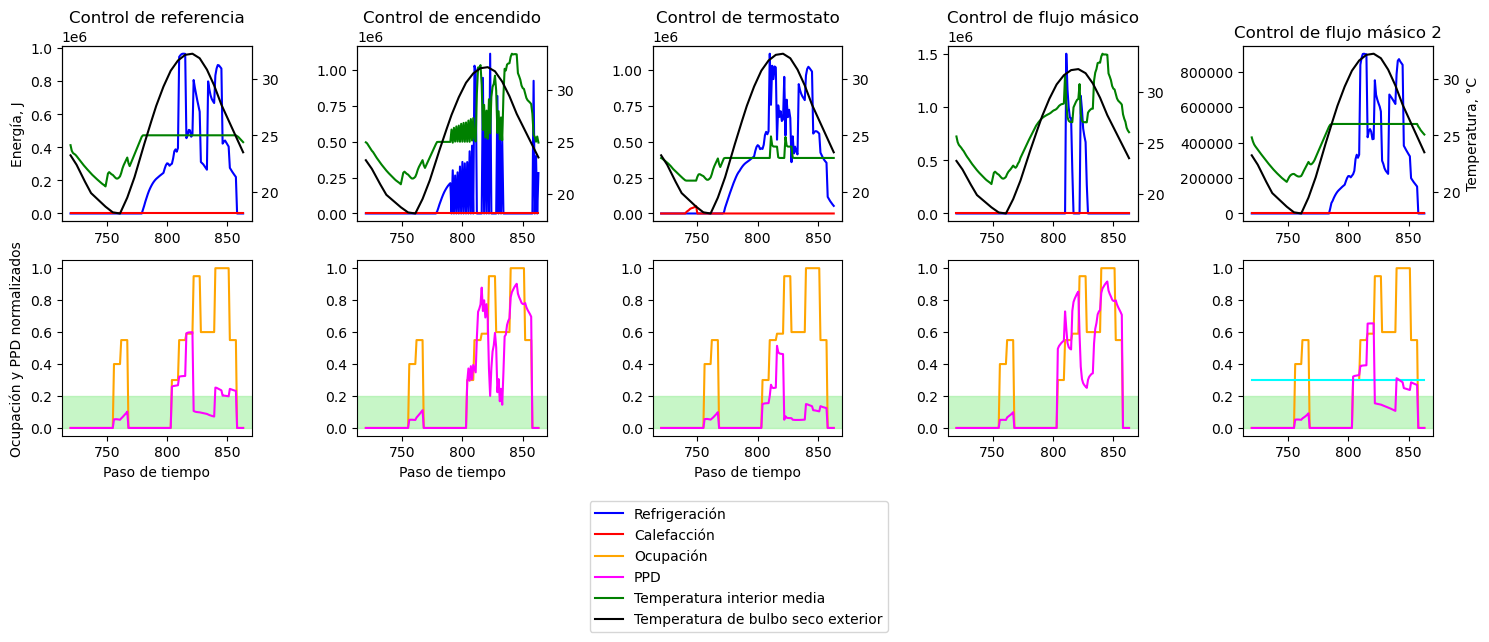

In [55]:
week = 5
a = 144*week
b = 144*(week+1)

policy_analisys(rb_data_cleaned, onoff_data_cleaned, therm_data_cleaned, mass_data_cleaned, mass2_data_cleaned, a, b, To=True)

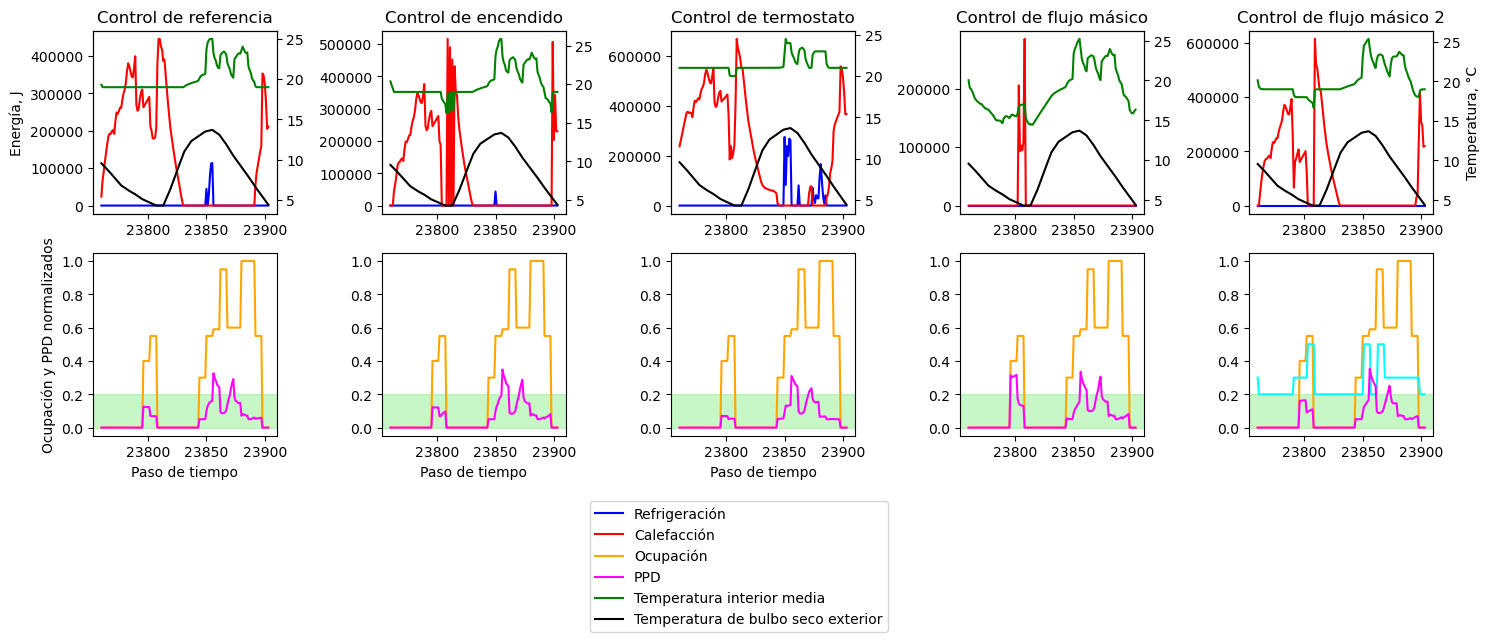

In [56]:
week = 165
a = 144*week
b = 144*(week+1)

policy_analisys(rb_data_cleaned, onoff_data_cleaned, therm_data_cleaned, mass_data_cleaned, mass2_data_cleaned, a, b, To=True)

In [43]:
# for day in range(32):
#     a = 144*day
#     b = 144*(day+1)
#     print(f"Esta gráfica corresponde al día {day}:")
#     policy_analisys(rb_data_cleaned, onoff_data_cleaned, therm_data_cleaned, mass_data_cleaned, a, b, To=True)

In [44]:
# for day in range(32,61):
#     a = 144*day
#     b = 144*(day+1)
#     print(f"Esta gráfica corresponde al día {day}:")
#     policy_analisys(rb_data_cleaned, onoff_data_cleaned, therm_data_cleaned, mass_data_cleaned, a, b, To=True)

In [45]:
# for day in range(61,93):
#     a = 144*day
#     b = 144*(day+1)
#     print(f"Esta gráfica corresponde al día {day}:")
#     policy_analisys(rb_data_cleaned, onoff_data_cleaned, therm_data_cleaned, mass_data_cleaned, a, b, To=True)

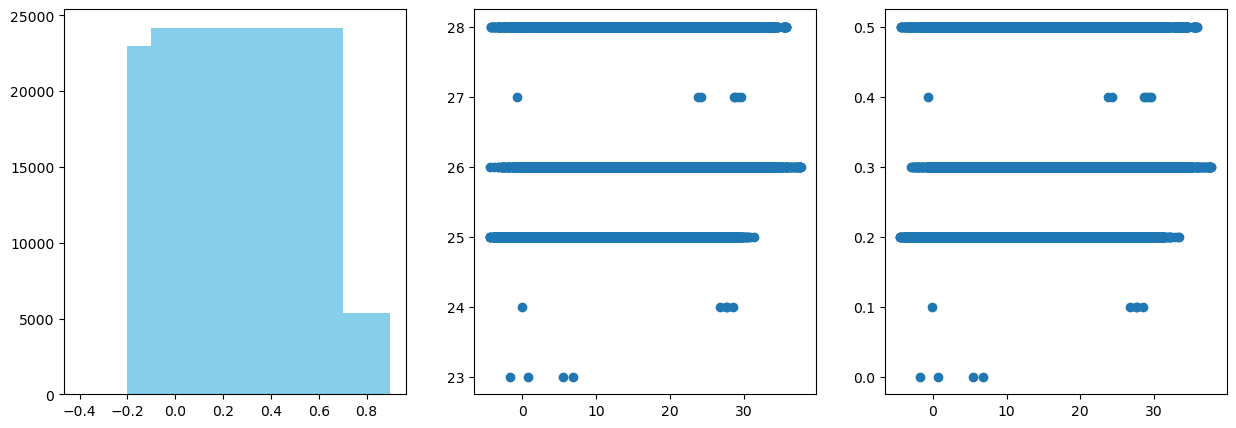

In [68]:
fig, axs = plt.subplots(1,3, figsize=(15, 5))

x = mass2_data_cleaned['To']
y0 = mass2_data_cleaned['heating_setpoint']
y1 = mass2_data_cleaned['cooling_setpoint']
y2 = mass2_data_cleaned['AirMassFlowRate']

# axs[0].scatter(x,y0)
axs[1].scatter(x,y1)
axs[2].scatter(x,y2)
# axs[0].hist(y2, bins=50, alpha=0.7)

y2 = mass2_data_cleaned['AirMassFlowRate'].value_counts()
axs[0].bar(y2.index, y2.values, color='skyblue')


plt.show()